In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from phd.feature_search.core.idbd import IDBD

%matplotlib inline

Number of steps: 17001
Loss: 0.022905479233609752


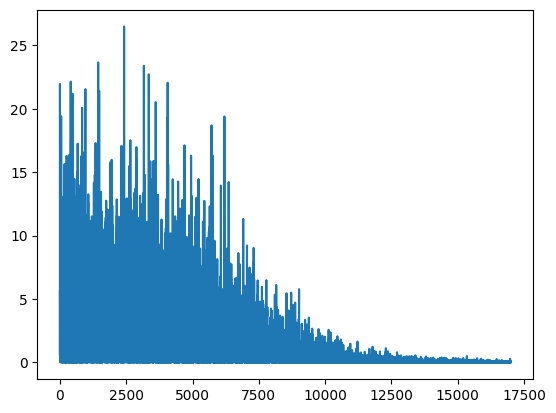

In [35]:
seed = 20250813
device = torch.device('cuda')

torch.manual_seed(seed)
data_generator = torch.Generator(device=device).manual_seed(seed)

n_inputs = 20
noise_strength = 0.0
n_distractors = 100000
convergence_threshold = 0.01

true_weights = torch.randn(1, n_inputs, device=device)
model = torch.nn.Linear(n_inputs + n_distractors, 1, bias=False).to(device)
torch.nn.init.zeros_(model.weight)

optimizer = IDBD(model.parameters(), meta_lr=0.005, init_lr=0.00001, autostep=True)

# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs + n_distractors,), dtype=torch.float, generator=data_generator, device=device)
    noisy_X = true_X + torch.randn(n_inputs + n_distractors, generator=data_generator, device=device) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X[:n_inputs]
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step(predictions=y_pred)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= convergence_threshold:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)

Number of steps: 4001
Loss: 0.5836347216171999


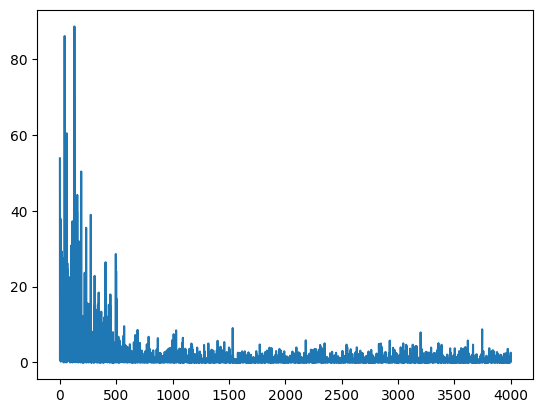

In [17]:
# Train until convergence

losses = []

for i in range(1000000):
    true_X = torch.randint(0, 2, (n_inputs,), dtype=torch.float)
    noisy_X = true_X + torch.randn(n_inputs) * noise_strength
    y_pred = model(noisy_X)
    target = true_weights @ true_X
    
    loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step(predictions=y_pred)
    
    if i > 2000 and i % 1000 == 0 and np.mean(losses[-2000:-1000]) - np.mean(losses[-1000:]) <= 0:
        break

print('Number of steps:', len(losses))
print('Loss:', np.mean(losses[-200:]))
plt.plot(losses)